In [1]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from matplotlib.colors import LogNorm

from glob import glob
import os, sys, pickle, requests
from sklearn.metrics import r2_score
from arnie.free_energy import free_energy
from arnie.mfe import mfe

from scipy.stats import pearsonr, spearmanr

def corrfunc(x,y, ax=None, **kws):
    r, pval = spearmanr(x, y)
    ax = ax or plt.gca()    
    m, b = np.poly1d(np.polyfit(x, y, 1))
    xmin, xmax = ax.get_xlim()
    plt.plot([xmin,xmax],[xmin*m+b,xmax*m+b],c='k',linestyle=':')
    ax.set_xlim([xmin,xmax])
    rho = '\u03C1'
    ax.annotate(f'R:{r:.2f}', xy=(.65, .9), xycoords=ax.transAxes)

Populating the interactive namespace from numpy and matplotlib


In [4]:
df = pd.read_csv('collated_predictions_all_models_233x.csv')
df['k_deg_full_length_normalize'] = df['k_deg_per_hour']/df['length']
df_filter = df.loc[df['single_exp_fit_ok']==1][df['k_deg_per_hour'] > 0]

df_filter = df_filter.loc[df_filter['Expt type']!='COV2 Eterna']
df_filter = df_filter.loc[df_filter['k_deg_err_per_hour'] < 0.15] #remove one spurious high error point

df_filter['half_life'] = np.log(2)/df_filter['k_deg_per_hour']
df_filter['half_life_err'] = df_filter['half_life']*df_filter['k_deg_err_per_hour']/df_filter['k_deg_per_hour']
df_filter['half_life_normalize'] = df_filter['half_life']*df_filter['RT_PCR_length']
df_filter['half_life_err_normalize'] = df_filter['half_life_err']*df_filter['RT_PCR_length']

/Users/hwayment/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


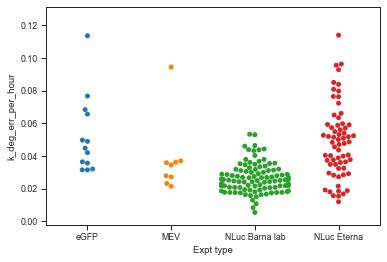

In [4]:
sns.swarmplot(x='Expt type', y='k_deg_err_per_hour', data=df_filter)

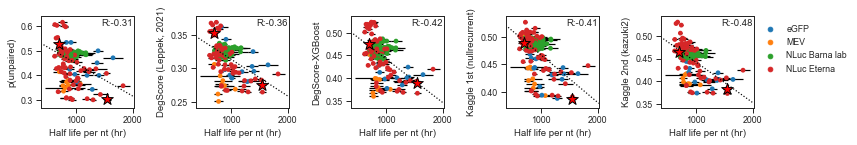

In [5]:
predictor_list = ['EternaFold', 'DegScore2.1', 'Degscore-XGB','nullrecurrent','kazuki2']

labels = ['p(unpaired)', 'DegScore (Leppek, 2021)', 'DegScore-XGBoost', 'Kaggle 1st (nullrecurrent)','Kaggle 2nd (kazuki2)']
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x-y)))

figure(figsize=(12,2))

nrows, ncols= 1,5
for i, k in enumerate(predictor_list):
    subplot(nrows, ncols,i+1)

    errorbar(df_filter['half_life_normalize'], df_filter['AUP %s PCR'% k], xerr = df_filter['half_life_err_normalize'],fmt='.', color='k', zorder=0, markersize=0 )
    sns.scatterplot(x='half_life_normalize', y='AUP %s PCR'% k, hue='Expt type', data = df_filter, linewidth=0)
    sns.scatterplot(x='half_life_normalize', y='AUP %s PCR'% k, data = df_filter.loc[df_filter['Human readable name'].str.contains('Yellowstone')], edgecolor='k', marker='*',color='red', s=150,zorder=10)
    sns.scatterplot(x='half_life_normalize', y='AUP %s PCR'% k, data = df_filter.loc[df_filter['Human readable name'].str.contains('jiabei')], edgecolor='k', marker='*',color='red', s=150,zorder=10)
    
    ylabel(labels[i])
    #xlim([0,0.0015])
    #xticks([0,0.0005, 0.001,0.0015], ['0','0.5', '1','1.5'])

    corrfunc(df_filter['half_life_normalize'], df_filter['AUP %s PCR'% k])
    #ylim([0,0.7])
    xlabel('Half life per nt (hr)')
    if i!=4:
        legend([],frameon=False)
    else:
        legend(bbox_to_anchor=(1,1),frameon=False)
    

tight_layout()
savefig('scatterplot_half_lives_233x_14Oct2021.pdf', bbox_inches='tight')
savefig('scatterplot_half_lives_233x_14Oct2021.png', dpi=300, bbox_inches='tight')

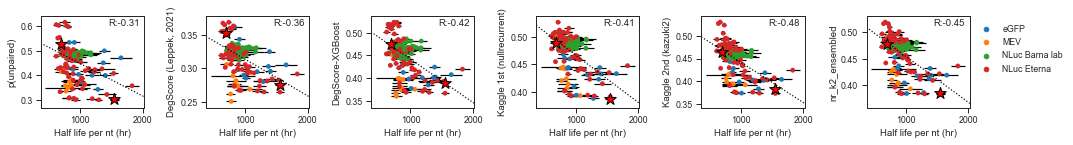

In [7]:
predictor_list = ['EternaFold', 'DegScore2.1', 'Degscore-XGB','nullrecurrent','kazuki2', 'nr_k2_ensembled']

labels = ['p(unpaired)', 'DegScore (Leppek, 2021)', 'DegScore-XGBoost', 'Kaggle 1st (nullrecurrent)','Kaggle 2nd (kazuki2)','nr_k2_ensembled']
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x-y)))

figure(figsize=(15,2))

nrows, ncols= 1,6
for i, k in enumerate(predictor_list):
    subplot(nrows, ncols,i+1)

    errorbar(df_filter['half_life_normalize'], df_filter['AUP %s PCR'% k], xerr = df_filter['half_life_err_normalize'],fmt='.', color='k', zorder=0, markersize=0 )
    sns.scatterplot(x='half_life_normalize', y='AUP %s PCR'% k, hue='Expt type', data = df_filter, linewidth=0)
    sns.scatterplot(x='half_life_normalize', y='AUP %s PCR'% k, data = df_filter.loc[df_filter['Human readable name'].str.contains('Yellowstone')], edgecolor='k', marker='*',color='red', s=150,zorder=10)
    sns.scatterplot(x='half_life_normalize', y='AUP %s PCR'% k, data = df_filter.loc[df_filter['Human readable name'].str.contains('jiabei')], edgecolor='k', marker='*',color='red', s=150,zorder=10)
    
    ylabel(labels[i])
    #xlim([0,0.0015])
    #xticks([0,0.0005, 0.001,0.0015], ['0','0.5', '1','1.5'])

    corrfunc(df_filter['half_life_normalize'], df_filter['AUP %s PCR'% k])
    #ylim([0,0.7])
    xlabel('Half life per nt (hr)')
    if i!=5:
        legend([],frameon=False)
    else:
        legend(bbox_to_anchor=(1,1),frameon=False)
    

tight_layout()
# savefig('scatterplot_half_lives_233x_14Oct2021.pdf', bbox_inches='tight')
# savefig('scatterplot_half_lives_233x_14Oct2021.png', dpi=300, bbox_inches='tight')

([], <a list of 0 Text yticklabel objects>)

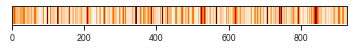

In [5]:
tmp = np.loadtxt('formatted_predictions/nullrecurrent_FULL_233x.csv',delimiter=',')
example_vec = tmp[109]

imshow(example_vec[:928].reshape(1,-1), aspect=50, cmap='gist_heat_r')
yticks([])

## Estimate experimental error upper limit on half-life - degradation rate spearman correlation

In [28]:
r_list=[]
for _ in range(100):
    tmp = df_filter.sample(frac=1)
    
    resampled_kdegs = np.random.normal(list(tmp['k_deg_per_hour'].values), list(tmp['k_deg_err_per_hour'].values))
    
    r, p = spearmanr(tmp['half_life'], resampled_kdegs)
    r_list.append(r)
                     
np.mean(r_list)

-0.9469598903391142

Not taking into account PCR start/end locations results in lower correlations overall, but with same trends.

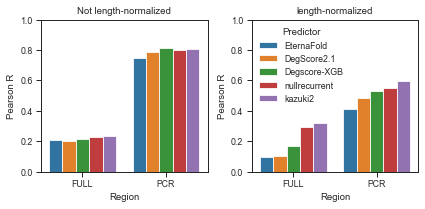

In [13]:
corr_df = pd.DataFrame()
corr_df_norm = pd.DataFrame()

for typ2 in ['FULL','PCR']:
    for pred in predictor_list:
        r, _ = pearsonr(df_filter["SUP %s %s" % (pred, typ2)], df_filter['k_deg_per_hour'])
        corr_df = corr_df.append({'Region':typ2, 'Pearson R': r,'Predictor':pred},ignore_index=True)
        
        if typ2=='FULL':
            r, _ = pearsonr(df_filter["AUP %s %s" % (pred, typ2)], df_filter['k_deg_full_length_normalize'])
        else:
            r, _ = pearsonr(df_filter["AUP %s %s" % (pred, typ2)], df_filter['k_deg_normalize'])

        corr_df_norm = corr_df_norm.append({'Region':typ2, 'Pearson R': r,'Predictor':pred},ignore_index=True)
        
figure(figsize=(6,3))

subplot(1,2,1)
sns.barplot(x='Region',y='Pearson R', data=corr_df, hue='Predictor')
title('Not length-normalized')
ylim([0,1])
legend([],frameon=False)

subplot(1,2,2)
title('length-normalized')
sns.barplot(x='Region',y='Pearson R', data=corr_df_norm, hue='Predictor')
ylim([0,1])
legend(title='Predictor', frameon=False)


tight_layout()